# Tutorial 1: FR-Match: A cell type matching algorithm for single cell RNA sequencing (scRNAseq) data

## Overview

### Workflow

General steps of FR-Match include:

- **Feature selection/dimensionality reduction** using the supervised **NS-Forest** marker gene selection algorithm or other informative marker gene set per user's choice. Our choice of the NS-Forest marker gene selection provides a minimum set of marker genes that maximize the classification power of differentiating clusters in the reference dataset.
- Construct **minimum spanning trees** for each pair of query and reference clusters.
- Calculate **FR statistics and p-values** based on the minimum spanning tree plots.

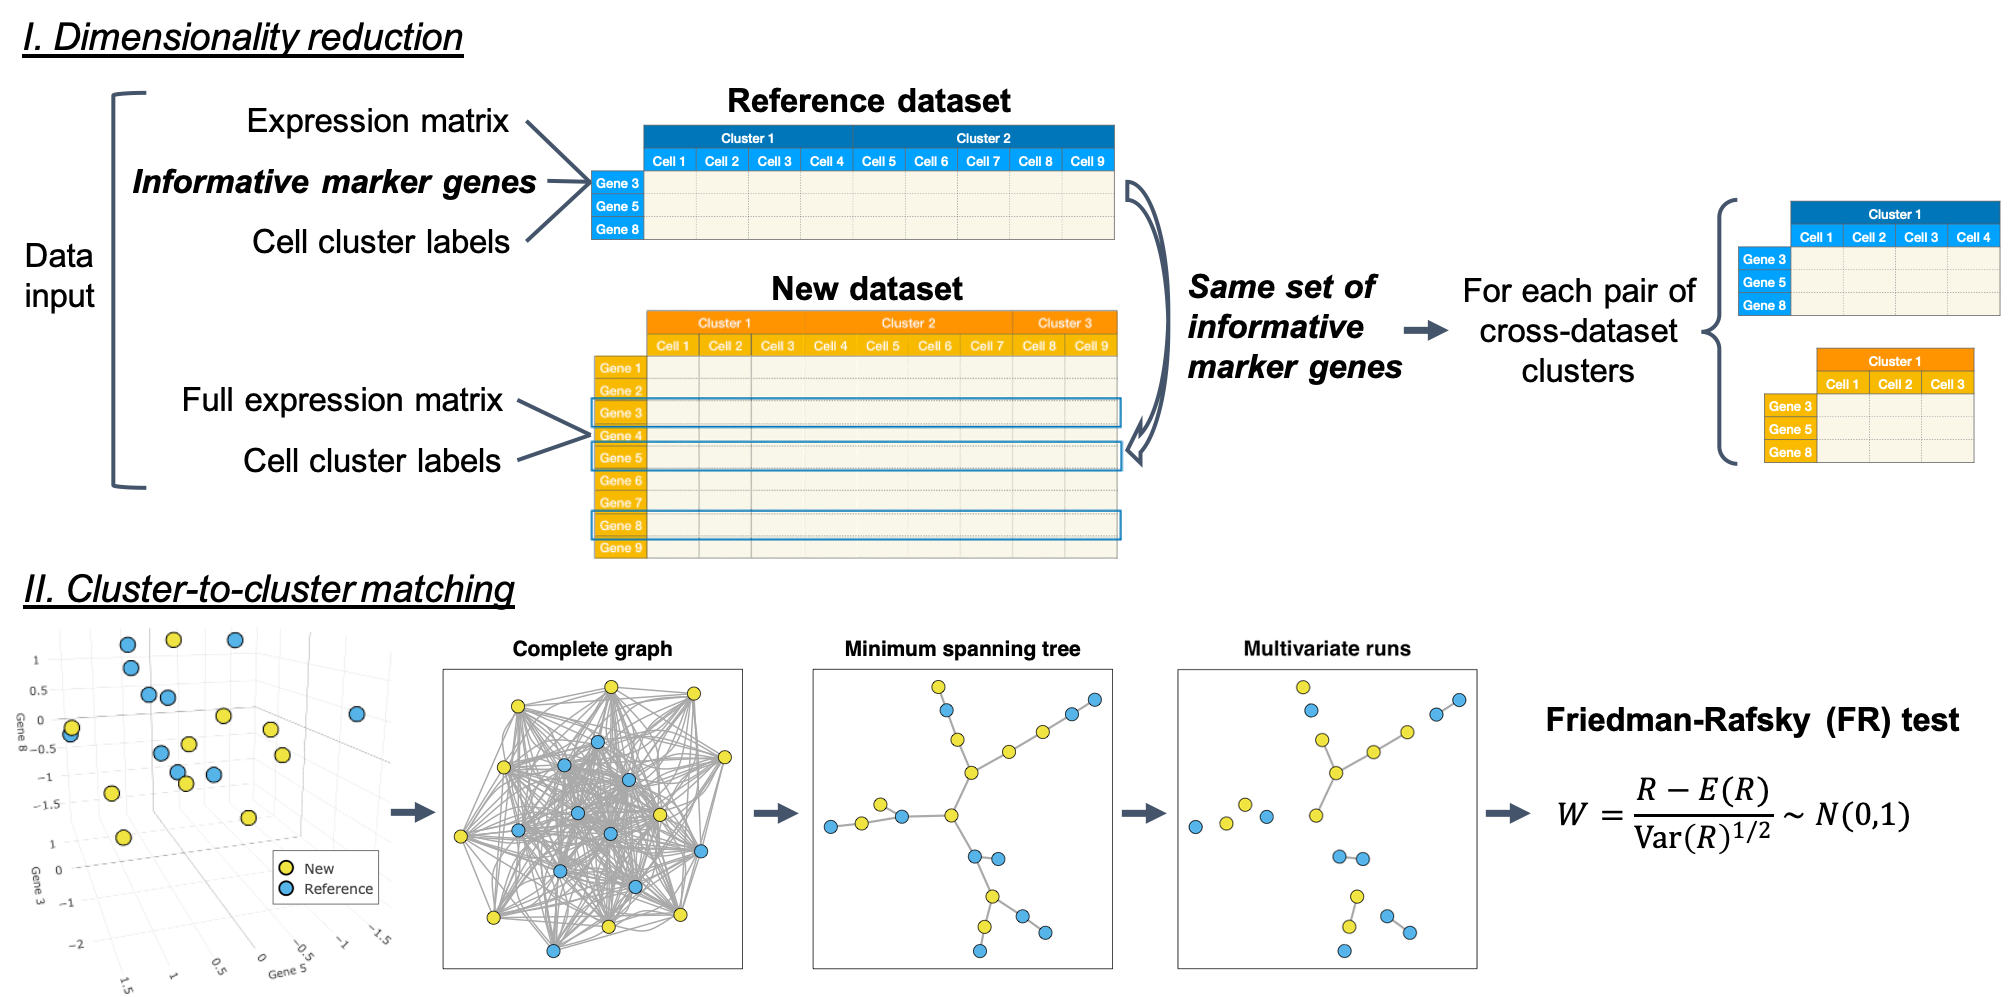

In [2]:
from IPython.display import Image
Image("../image.png")

Overview of FR-Match for cross-comparison between two scRNAseq experiments.

### Installation

To install from GitHub repository,
...

After successful installation, load FR-Match and other useful packages to your R environment.
...

In [8]:
import os
import sys
CODE_PATH = "../" # location of FRmatch folder
sys.path.insert(0, os.path.abspath(CODE_PATH))
# sys.path.insert(0, os.path.abspath("./FRmatch"))
import FRmatch
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
output_dir = "../outputs_tutorial1"

## Getting data ready

### Input data

FR-Match is a cell type matching method for two independently conducted scRNAseq experiments, namely, query and reference. For each experiment, FR-Match takes in the following input data:

- Reference dataset
  - A cell-by-gene expression matrix
  - Cell type cluster membership
  - Informative marker genes for the reference cell types

- Query dataset
  - A cell-by-gene expression matrix
  - Cell type cluster membership

There are many pieces of data information needed for various scRNAseq data analyses. We choose to use the AnnData class to organize the input data, which is a convenient container for scRNAseq data. 

For an FR-Match data object, the following data are essential:
- a gene expression data matrix (adata.X)
- cell type cluster labels (adata.obs[cluster_header])
- NS-Forest or your own marker genes for the reference dataset (adata.uns["nsforest_results"])

In addition, metadata such as F-beta score and cluster order are not essential for the core matching algorithm, but these information will facilitate visualization and other customized analysis tools provided in this package.

### An example data object

In [3]:
adata_layer1 = sc.read_h5ad("demo_data/adata_layer1_R_frmatch.h5ad")
cluster_header = "cluster_membership"
adata_layer1

AnnData object with n_obs × n_vars = 865 × 128
    obs: 'cluster_membership'
    uns: 'dendrogram_cluster_membership', 'markers', 'markers_per_cluster'

### Layer 1 and full MTG data

Here, we introduce two datasets to be used in this vignette. Both datasets are generated by the Allen Institute for Brain Science using Smart-seq2 protocol for single nucleus RNA sequencing. The first is the pre-containerized dataset in the data object sce.example, which is sampled from a single layer (layer 1) of cerebral cortex from the middle temporal gyrus (MTG) region of human brain (Boldog et al., 2018). In the layer 1 dataset, there are 16487 genes and 865 cells; 15 cell type clusters are identified and labeled by the authors.

In [4]:
adata_layer1.obs[cluster_header].value_counts()

e1_e299_SLC17A7_L5b_Cdh13     299
i1_i90_COL5A2_Ndnf_Car4        90
i2_i77_LHX6_Sst_Cbln4          77
i3_i56_BAGE2_Ndnf_Cxcl14       56
i4_i54_MC4R_Ndnf_Cxcl14        54
g1_g48_GLI3_Astro_Gja1         48
i5_i47_TRPC3_Ndnf_Car4         47
i6_i44_GPR149_Vip_Mybpc1       44
i7_i31_CLMP_Ndnf_Cxcl14        31
g2_g27_APBB1IP_Micro_Ctss      27
i8_i27_SNCG_Vip_Mybpc1         27
i9_i22_TAC3_Vip_Mybpc1         22
g3_g18_GPNMB_OPC_Pdgfra        18
i10_i16_TSPAN12_Vip_Mybpc1     16
g4_g9_MOG_Oligo_Opalin          9
Name: cluster_membership, dtype: int64

The second dataset is sampled from the full laminar depth (layer 1-6) of the MTG cerebral cortex (Hodge et al., 2019). The MTG dataset consist of 13945 genes and 15603 cells; 75 cell type clusters are identified and labeled by the authors. We are going to devote the next section to introduce a function that compiles the necessary input data files from the MTG dataset into a data object that can be used in our matching function.

**The biological ground truth** is that these two datasets are from neuroanatomical overlapping regions, therefore, we would expect each layer 1 cell type to be matched with one full MTG cell type. Good matches should reflect the laminar characteristics of these cell types, i.e. matches should be found in the upper layer cell types of the full MTG dataset.

### Construct data object using make_data_object()

The following raw data files are here (https://github.com/JCVenterInstitute/celligrate-data/tree/main/AIBS_MTG_data).

In [5]:
# # MTG takes a bit to run
# cluster_header = "Clusters"
# folder = "demo_data/AIBS_MTG_data/"
# cell_by_gene = pd.read_csv(folder + "cell_by_gene_expression.csv", index_col = 0)
# cluster_labels = pd.read_csv(folder + "cell_cluster_labels.csv", index_col = 0)
# taxonomy = list(pd.read_csv(folder + "MTG_taxonomy.csv")["x"])
# # nsforest_results = pd.read_csv(folder + "NSForest_fscores.csv", index_col = 0).rename(columns = {"f-measure": "f_score"})
# marker_genes = pd.read_csv(folder + "NSForest_marker_genes.csv", index_col = 0)

Use the FRmatch.create_frmatch_object_mtx() function to compile the pieces of input data into a data object.

In [6]:
# filename = "demo_data/adata_mtg_frmatch.h5ad"
# adata = FRmatch.create_frmatch_object_mtx(cell_by_gene, cluster_labels, marker_genes, "markerGene", taxonomy, save = filename)
# adata

It may cause some confusion on the cell-by-gene or gene-by-cell orientation of the expression data. To be clear, the raw input data (.csv or .txt file) for gene expression should have cells in rows and genes in columns (cell-by-gene). After the input data is read into the data object (e.g. sce.example), the expression data is stored as genes in rows and cells in columns (gene-by-cell). We made such arrangement because conventionally R packages, such as Seurat, deal with gene-by-cell expression data; and Python packages, such as Scanpy, deal with cell-by-gene expression data.

In [7]:
# Or preload anndata object
adata_mtg = sc.read_h5ad("demo_data/adata_MTG_R_frmatch.h5ad")
cluster_header = "Clusters"
adata_mtg

AnnData object with n_obs × n_vars = 15603 × 175
    obs: 'Clusters'
    uns: 'dendrogram_Clusters', 'markers', 'markers_per_cluster'

## FR-Match

### Cell type “barcode”

In the FR-Match workflow, we utilize the informative marker genes for dimensionality reduction. Good marker genes display on-off binary expression pattern producing, in combination, a unique gene expression “barcode” for each cell type cluster. We provide the plot_cluster_by_markers() function for plotting the marker gene expression patterns for a random set of cells in each cluster, visualizing the cell type “barcode”. Examples below show that the “barcodes” for excitatory cell type, glial cell type, and inhibitory cell type from the layer 1 data are distinctively different using the NS-Forest marker genes.

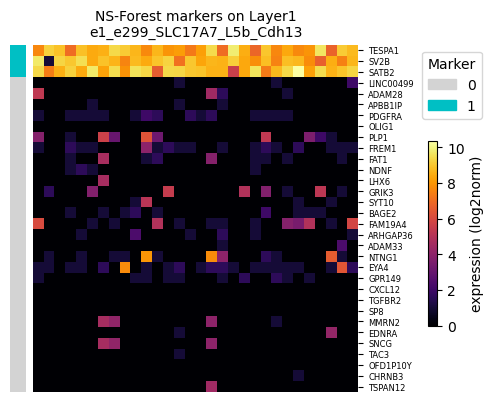

In [8]:
FRmatch.plot_cluster_by_markers(adata_layer1, "cluster_membership", "e1_e299_SLC17A7_L5b_Cdh13", 
                                markers = adata_layer1.uns["markers"], 
                                colorbar_loc = (0, 0.48), marker_legend_loc = (1.4, 1), 
                                name_adata = "Layer1", name_markers = "NS-Forest")

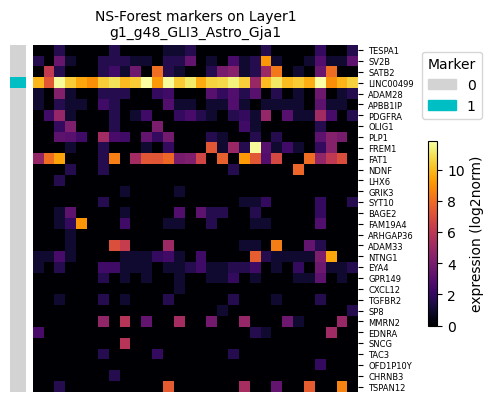

In [9]:
FRmatch.plot_cluster_by_markers(adata_layer1, "cluster_membership", "g1_g48_GLI3_Astro_Gja1", 
                                markers = adata_layer1.uns["markers"], 
                                colorbar_loc = (0, 0.48), marker_legend_loc = (1.4, 1), 
                                name_adata = "Layer1", name_markers = "NS-Forest")

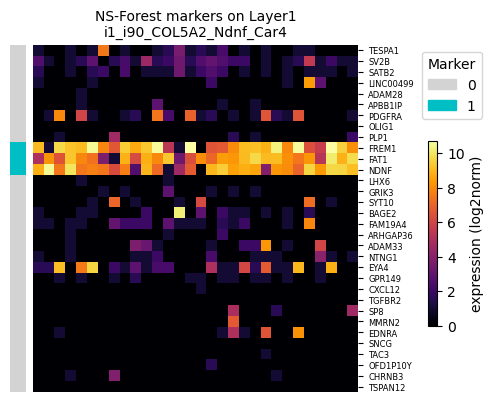

In [10]:
FRmatch.plot_cluster_by_markers(adata_layer1, "cluster_membership", "i1_i90_COL5A2_Ndnf_Car4", 
                                markers = adata_layer1.uns["markers"], 
                                colorbar_loc = (0, 0.48), marker_legend_loc = (1.4, 1), 
                                name_adata = "Layer1", name_markers = "NS-Forest")

### Cluster sizes

Take a look at the cluster sizes in these two datasets.

C:\Users\bpeng\Documents\frmatch\FRmatch\plot_clusterSize.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(dictionary.keys(), rotation = 90)
C:\Users\bpeng\Documents\frmatch\FRmatch\plot_clusterSize.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(dictionary.keys(), rotation = 90)


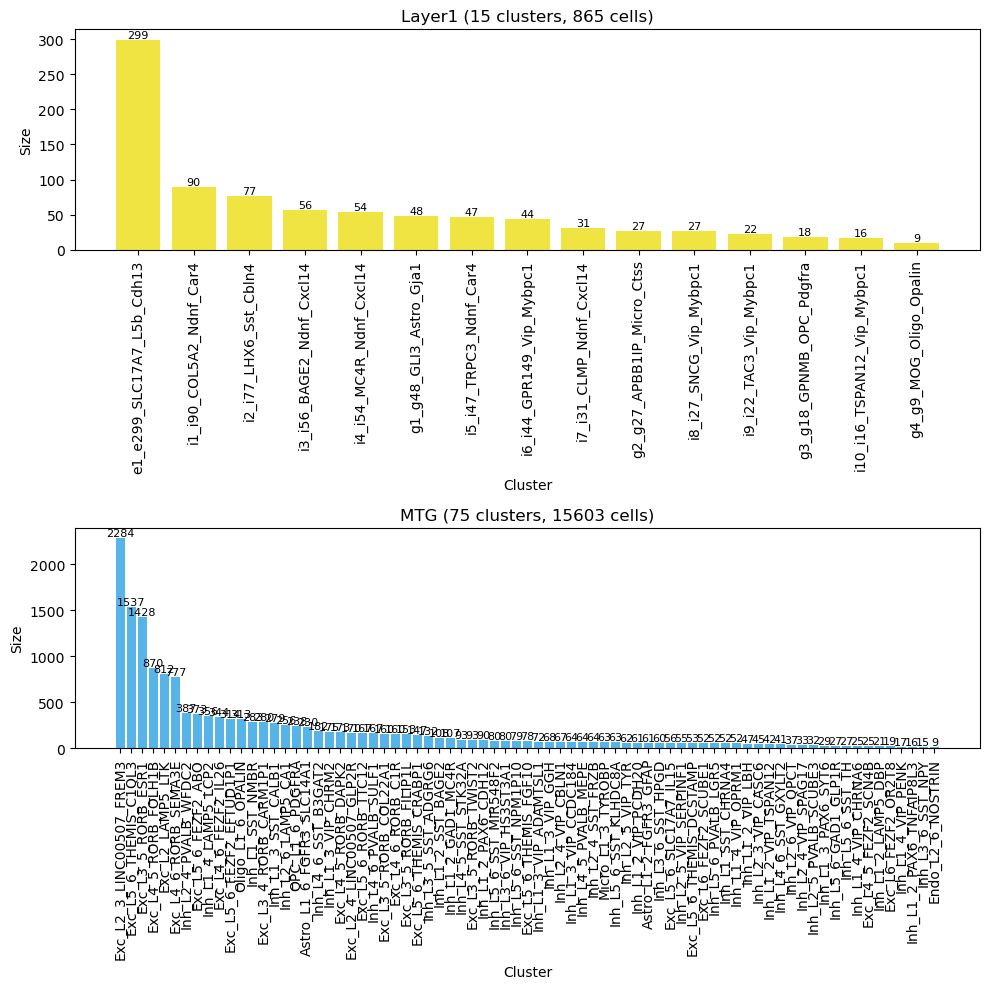

In [11]:
FRmatch.plot_clusterSize(adata_layer1, "cluster_membership", adata_mtg, "Clusters", name_E1 = "Layer1", name_E2 = "MTG")

C:\Users\bpeng\Documents\frmatch\FRmatch\plot_clusterSize.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dictionary.keys(), rotation = 90)


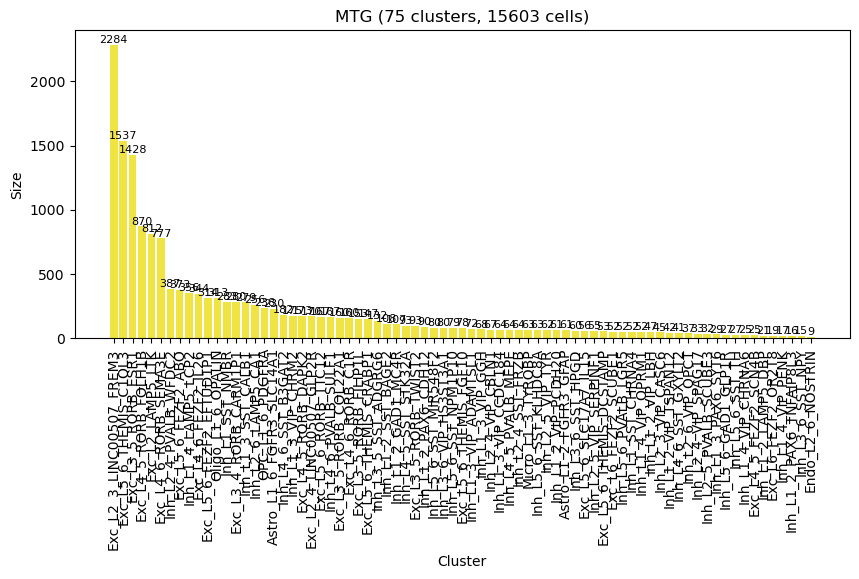

In [12]:
# Running individual clusterSize
FRmatch.plot_clusterSize(adata_mtg, "Clusters", name_E1 = "MTG", height = 4)

Note that cluster sizes range widely, which may cause the unbalance cluster size issue in the FR test.

### Run FRmatch_main()

The FRmatch_main() function is a wrapper function that takes in two input data objects in the **adata_query and adata_ref arguments**. By performing this function, it carries out our matching workflow in default setting. To start, let’s regard adata_layer1 as the query data and adata_mtg as the reference data.

In [13]:
# # Running on subset to test
# results_MTGtolayer1 = FRmatch.FRmatch_cluster2cluster(adata_mtg[adata_mtg.obs["Clusters"] == "Inh_L1_2_SST_BAGE2",:], 
#                                                       adata_layer1[adata_layer1.obs["cluster_membership"] == "e1_e299_SLC17A7_L5b_Cdh13",:], 
#                                                       cluster_header_query = "Clusters", 
#                                                       cluster_header_ref = "cluster_membership", 
#                                                       subsamp_size = 10, subsamp_iter = 100, save_as = "results.pkl")

In [14]:
# %%time
# results_layer1toMTG = FRmatch.FRmatch_cluster2cluster(adata_layer1, adata_mtg, cluster_header_query = "cluster_membership", 
#                                                       cluster_header_ref = "Clusters", 
#                                                       subsamp_size = 10, subsamp_iter = 1000, 
#                                                       save_as = f"{output_dir}/results_layer1toMTG_R_size10_iter1000.pkl")
# # Wall time: 15min 11s - results_layer1toMTG_R_size10_iter100
# # Wall time: 2h 33min 27s - results_layer1toMTG_R_size10_iter1000
# # Wall time: 7h 8min 3s - results_layer1toMTG_R_size20_iter1000

In [15]:
# %%time
# results_MTGtolayer1 = FRmatch.FRmatch_cluster2cluster(adata_mtg, adata_layer1, cluster_header_query = "Clusters", 
#                                                       cluster_header_ref = "cluster_membership", 
#                                                       subsamp_size = 10, subsamp_iter = 1000, 
#                                                       save_as = "results_MTGtolayer1_R_size10_iter1000.pkl")
# # Wall time: 12min 18s - results_MTGtolayer1_R_size10_iter100
# # Wall time: 1h 27min 35s - results_MTGtolayer1_R_size10_iter1000
# # Wall time: 5h 22min 47s - results_MTGtolayer1_R_size20_iter1000

In [16]:
# # Saving results
# results_layer1toMTG.to_csv("results_layer1toMTG_R_size10_iter100.csv", index = True)
# results_MTGtolayer1.to_csv("results_MTGtolayer1_R_size10_iter100_R.csv", index = True)

#### A few remarks:

- Note that not all clusters are passed to the matching algorithm. In the default setting, query and reference clusters with less 10 cells are filtered out. This is can be tuned using the filter_size argument. It is also optional to filter clusters based on F-beta score using the filter.fscore = argument.
- FRmatch_main() uses an iterative subsampling scheme to overcome the unbalanced cluster sizes between the query and reference clusters when applying the FR test. The subsampling parameters are subsamp_size, subsamp_iter, subsamp_seed.
- Due to the iterative scheme, it may take some computational time. We provide the numCores = argument to specific the number of cores to utilize for parallel computing.

Also, we may want to swap the query and reference data to perform FR-Match in the other direction. In practice, if we want to match between two independently conducted experiments (for example, each experiment may focus on a different specimen region, inducing different cell type clusters and different set of marker genes), different directions of matching may lead to quiet different matching results. We recommend to perform both directions of matching, and conclude with a consensus matching results from both directions.

The FRmatch_main() output is a dataframe of p-values. The best way to present these results is to use our customized plotting functions.

In [17]:
# Or preload FR-Match results
with open('results_layer1toMTG_R_size10_iter1000.pkl', 'rb') as f: 
    results_layer1toMTG_3 = pickle.load(f)
print(results_layer1toMTG_3.keys())
with open('results_MTGtolayer1_R_size10_iter1000.pkl', 'rb') as f: 
    results_MTGtolayer1_3 = pickle.load(f)
print(results_MTGtolayer1_3.keys())
print(results_MTGtolayer1_3["settings"])

dict_keys(['settings', 'p_values', 'stat'])
dict_keys(['settings', 'p_values', 'stat'])
{'query': 'query', 'ref': 'ref', 'cluster_header_query': 'Clusters', 'cluster_header_ref': 'cluster_membership', 'marker_genes': [], 'use_cosine': True, 'filter_size': 5, 'subsamp_size': 10, 'subsamp_iter': 1000, 'subsamp_seed': False, 'return_all': False, 'save_as': 'results_MTGtolayer1_R_size10_iter1000.pkl'}


In [18]:
results_layer1toMTG = results_layer1toMTG_3["p_values"].copy()
results_MTGtolayer1 = results_MTGtolayer1_3["p_values"].copy()
results_layer1toMTG.columns.name = None
results_layer1toMTG.index.name = None
results_MTGtolayer1.columns.name = None
results_MTGtolayer1.index.name = None

# results_layer1toMTG = pd.read_csv("old_results/results_layer1toMTG_R.csv", index_col = 0)
# results_MTGtolayer1 = pd.read_csv("old_results/results_MTGtolayer1_R.csv", index_col = 0)
# results_layer1toMTG = results_layer1toMTG.pivot(index = "ref_cluster", columns = "query_cluster", values = "p_value")
# results_MTGtolayer1 = results_MTGtolayer1.pivot(index = "ref_cluster", columns = "query_cluster", values = "p_value")

# Custom sorting columns
colnames = ['i7_i31_CLMP_Ndnf_Cxcl14', 'i1_i90_COL5A2_Ndnf_Car4', 'i5_i47_TRPC3_Ndnf_Car4', 'i4_i54_MC4R_Ndnf_Cxcl14', 
            'i3_i56_BAGE2_Ndnf_Cxcl14', 'i10_i16_TSPAN12_Vip_Mybpc1', 'i9_i22_TAC3_Vip_Mybpc1', 'i6_i44_GPR149_Vip_Mybpc1', 
            'i8_i27_SNCG_Vip_Mybpc1', 'i2_i77_LHX6_Sst_Cbln4', 'e1_e299_SLC17A7_L5b_Cdh13', 'g3_g18_GPNMB_OPC_Pdgfra', 
            'g1_g48_GLI3_Astro_Gja1', 'g4_g9_MOG_Oligo_Opalin', 'g2_g27_APBB1IP_Micro_Ctss']
rownames = ['Inh_L1_2_PAX6_CDH12', 'Inh_L1_2_PAX6_TNFAIP8L3', 'Inh_L1_SST_NMBR', 'Inh_L1_4_LAMP5_LCP2', 'Inh_L1_2_LAMP5_DBP', 'Inh_L2_6_LAMP5_CA1', 'Inh_L1_SST_CHRNA4', 'Inh_L1_2_GAD1_MC4R', 'Inh_L1_2_SST_BAGE2', 'Inh_L1_3_PAX6_SYT6', 'Inh_L1_2_VIP_TSPAN12', 'Inh_L1_4_VIP_CHRNA6', 'Inh_L1_3_VIP_ADAMTSL1', 'Inh_L1_4_VIP_PENK', 'Inh_L2_6_VIP_QPCT', 'Inh_L3_6_VIP_HS3ST3A1', 'Inh_L1_2_VIP_PCDH20', 'Inh_L2_5_VIP_SERPINF1', 'Inh_L2_5_VIP_TYR', 'Inh_L1_3_VIP_CHRM2', 'Inh_L2_4_VIP_CBLN1', 'Inh_L1_3_VIP_CCDC184', 'Inh_L1_3_VIP_GGH', 'Inh_L1_2_VIP_LBH', 'Inh_L2_3_VIP_CASC6', 'Inh_L2_4_VIP_SPAG17', 'Inh_L1_4_VIP_OPRM1', 'Inh_L3_6_SST_NPY', 'Inh_L3_6_SST_HPGD', 'Inh_L4_6_SST_B3GAT2', 'Inh_L5_6_SST_KLHDC8A', 'Inh_L5_6_SST_NPM1P10', 'Inh_L4_6_SST_GXYLT2', 'Inh_L4_5_SST_STK32A', 'Inh_L1_3_SST_CALB1', 'Inh_L3_5_SST_ADGRG6', 'Inh_L2_4_SST_FRZB', 'Inh_L5_6_SST_TH', 'Inh_L5_6_GAD1_GLP1R', 'Inh_L5_6_PVALB_LGR5', 'Inh_L4_5_PVALB_MEPE', 'Inh_L2_4_PVALB_WFDC2', 'Inh_L4_6_PVALB_SULF1', 'Inh_L5_6_SST_MIR548F2', 'Inh_L2_5_PVALB_SCUBE3', 'Exc_L2_LAMP5_LTK', 'Exc_L2_4_LINC00507_GLP2R', 'Exc_L2_3_LINC00507_FREM3', 'Exc_L5_6_THEMIS_C1QL3', 'Exc_L3_4_RORB_CARM1P1', 'Exc_L3_5_RORB_ESR1', 'Exc_L3_5_RORB_COL22A1', 'Exc_L3_5_RORB_FILIP1L', 'Exc_L3_5_RORB_TWIST2', 'Exc_L4_5_RORB_FOLH1B', 'Exc_L4_6_RORB_SEMA3E', 'Exc_L4_5_RORB_DAPK2', 'Exc_L5_6_RORB_TTC12', 'Exc_L4_6_RORB_C1R', 'Exc_L4_5_FEZF2_SCN4B', 'Exc_L5_6_THEMIS_DCSTAMP', 'Exc_L5_6_THEMIS_CRABP1', 'Exc_L5_6_THEMIS_FGF10', 'Exc_L4_6_FEZF2_IL26', 'Exc_L5_6_FEZF2_ABO', 'Exc_L6_FEZF2_SCUBE1', 'Exc_L5_6_SLC17A7_IL15', 'Exc_L6_FEZF2_OR2T8', 'Exc_L5_6_FEZF2_EFTUD1P1', 'OPC_L1_6_PDGFRA', 'Astro_L1_6_FGFR3_SLC14A1', 'Astro_L1_2_FGFR3_GFAP', 'Oligo_L1_6_OPALIN', 'Endo_L2_6_NOSTRIN', 'Micro_L1_3_TYROBP']
results_layer1toMTG = results_layer1toMTG.iloc[pd.Categorical(results_layer1toMTG.index, rownames).argsort()]
results_layer1toMTG = results_layer1toMTG[colnames]

colnames = ['e1_e299_SLC17A7_L5b_Cdh13', 'g1_g48_GLI3_Astro_Gja1', 'g2_g27_APBB1IP_Micro_Ctss', 'g3_g18_GPNMB_OPC_Pdgfra', 
            'g4_g9_MOG_Oligo_Opalin', 'i1_i90_COL5A2_Ndnf_Car4','i2_i77_LHX6_Sst_Cbln4', 'i3_i56_BAGE2_Ndnf_Cxcl14', 
            'i4_i54_MC4R_Ndnf_Cxcl14',  'i5_i47_TRPC3_Ndnf_Car4', 'i6_i44_GPR149_Vip_Mybpc1', 'i7_i31_CLMP_Ndnf_Cxcl14', 
            'i8_i27_SNCG_Vip_Mybpc1', 'i9_i22_TAC3_Vip_Mybpc1', 'i10_i16_TSPAN12_Vip_Mybpc1']
rownames = ['Exc_L2_LAMP5_LTK', 'Exc_L2_4_LINC00507_GLP2R', 'Exc_L2_3_LINC00507_FREM3', 'Astro_L1_6_FGFR3_SLC14A1', 'Astro_L1_2_FGFR3_GFAP', 'Micro_L1_3_TYROBP', 'OPC_L1_6_PDGFRA', 'Oligo_L1_6_OPALIN', 'Inh_L1_SST_NMBR', 'Inh_L3_6_SST_NPY', 'Inh_L5_6_SST_KLHDC8A', 'Inh_L4_6_SST_GXYLT2', 'Inh_L1_3_SST_CALB1', 'Inh_L2_4_SST_FRZB', 'Inh_L2_4_PVALB_WFDC2', 'Inh_L5_6_SST_MIR548F2', 'Inh_L3_5_SST_ADGRG6', 'Inh_L5_6_SST_TH', 'Inh_L4_6_PVALB_SULF1', 'Inh_L1_2_SST_BAGE2', 'Inh_L1_SST_CHRNA4', 'Inh_L1_2_GAD1_MC4R', 'Inh_L1_4_LAMP5_LCP2','Inh_L2_6_VIP_QPCT', 'Inh_L1_2_VIP_PCDH20', 'Inh_L1_3_VIP_CHRM2', 'Inh_L2_4_VIP_SPAG17', 'Inh_L1_3_VIP_GGH', 'Inh_L1_4_VIP_OPRM1', 'Inh_L1_3_VIP_CCDC184', 'Inh_L2_4_VIP_CBLN1', 'Inh_L3_6_VIP_HS3ST3A1', 'Inh_L1_2_PAX6_CDH12', 'Inh_L2_3_VIP_CASC6', 'Inh_L1_2_VIP_LBH', 'Inh_L2_5_VIP_SERPINF1', 'Inh_L2_5_VIP_TYR', 'Inh_L1_3_PAX6_SYT6', 'Inh_L1_4_VIP_CHRNA6', 'Inh_L1_2_VIP_TSPAN12', 'Inh_L1_2_PAX6_TNFAIP8L3', 'Inh_L2_6_LAMP5_CA1', 'Inh_L1_3_VIP_ADAMTSL1', 'Inh_L3_6_SST_HPGD', 'Inh_L5_6_SST_NPM1P10', 'Inh_L5_6_GAD1_GLP1R', 'Inh_L4_5_PVALB_MEPE', 'Inh_L2_5_PVALB_SCUBE3', 'Exc_L5_6_THEMIS_C1QL3', 'Exc_L3_5_RORB_ESR1', 'Exc_L3_5_RORB_FILIP1L', 'Exc_L4_5_RORB_FOLH1B', 'Exc_L4_5_RORB_DAPK2', 'Exc_L4_6_RORB_C1R', 'Exc_L5_6_THEMIS_DCSTAMP', 'Exc_L5_6_THEMIS_FGF10', 'Exc_L5_6_FEZF2_ABO', 'Exc_L5_6_SLC17A7_IL15', 'Exc_L5_6_FEZF2_EFTUD1P1', 'Inh_L1_2_LAMP5_DBP', 'Inh_L1_4_VIP_PENK', 'Inh_L4_6_SST_B3GAT2', 'Inh_L4_5_SST_STK32A', 'Inh_L5_6_PVALB_LGR5', 'Exc_L3_4_RORB_CARM1P1', 'Exc_L3_5_RORB_COL22A1', 'Exc_L3_5_RORB_TWIST2', 'Exc_L4_6_RORB_SEMA3E', 'Exc_L5_6_RORB_TTC12', 'Exc_L4_5_FEZF2_SCN4B', 'Exc_L5_6_THEMIS_CRABP1', 'Exc_L4_6_FEZF2_IL26', 'Exc_L6_FEZF2_SCUBE1', 'Exc_L6_FEZF2_OR2T8','Endo_L2_6_NOSTRIN']
results_MTGtolayer1 = results_MTGtolayer1.iloc[pd.Categorical(results_MTGtolayer1.index, colnames).argsort()]
results_MTGtolayer1 = results_MTGtolayer1[rownames]
results_MTGtolayer1

,Exc_L2_LAMP5_LTK,Exc_L2_4_LINC00507_GLP2R,Exc_L2_3_LINC00507_FREM3,Astro_L1_6_FGFR3_SLC14A1,Astro_L1_2_FGFR3_GFAP,Micro_L1_3_TYROBP,OPC_L1_6_PDGFRA,Oligo_L1_6_OPALIN,Inh_L1_SST_NMBR,Inh_L3_6_SST_NPY,Inh_L5_6_SST_KLHDC8A,Inh_L4_6_SST_GXYLT2,Inh_L1_3_SST_CALB1,Inh_L2_4_SST_FRZB,Inh_L2_4_PVALB_WFDC2,Inh_L5_6_SST_MIR548F2,Inh_L3_5_SST_ADGRG6,Inh_L5_6_SST_TH,Inh_L4_6_PVALB_SULF1,Inh_L1_2_SST_BAGE2,Inh_L1_SST_CHRNA4,Inh_L1_2_GAD1_MC4R,Inh_L1_4_LAMP5_LCP2,Inh_L2_6_VIP_QPCT,Inh_L1_2_VIP_PCDH20,...,Exc_L3_5_RORB_FILIP1L,Exc_L4_5_RORB_FOLH1B,Exc_L4_5_RORB_DAPK2,Exc_L4_6_RORB_C1R,Exc_L5_6_THEMIS_DCSTAMP,Exc_L5_6_THEMIS_FGF10,Exc_L5_6_FEZF2_ABO,Exc_L5_6_SLC17A7_IL15,Exc_L5_6_FEZF2_EFTUD1P1,Inh_L1_2_LAMP5_DBP,Inh_L1_4_VIP_PENK,Inh_L4_6_SST_B3GAT2,Inh_L4_5_SST_STK32A,Inh_L5_6_PVALB_LGR5,Exc_L3_4_RORB_CARM1P1,Exc_L3_5_RORB_COL22A1,Exc_L3_5_RORB_TWIST2,Exc_L4_6_RORB_SEMA3E,Exc_L5_6_RORB_TTC12,Exc_L4_5_FEZF2_SCN4B,Exc_L5_6_THEMIS_CRABP1,Exc_L4_6_FEZF2_IL26,Exc_L6_FEZF2_SCUBE1,Exc_L6_FEZF2_OR2T8,Endo_L2_6_NOSTRIN
e1_e299_SLC17A7_L5b_Cdh13,0.171764,0.162162,0.009141,0.000011,0.000012,0.000011,0.000010,0.000011,0.000011,0.000010,0.000011,0.000011,0.000011,0.000010,0.000010,0.000010,0.000011,0.000010,0.000011,0.000011,0.000011,0.000011,0.000010,0.000013,0.000011,...,0.000011,0.000072,0.000012,0.000010,0.000068,0.000088,0.000014,0.000061,0.000072,0.000010,0.000011,0.000011,0.000011,0.000009,0.000010,0.000072,0.001391,0.000011,0.000061,0.000012,0.000012,0.000011,0.000051,0.000010,0.000129
g1_g48_GLI3_Astro_Gja1,0.000010,0.000010,0.000011,0.316104,0.317889,0.000011,0.000010,0.000012,0.000011,0.000010,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000012,0.000011,0.000011,0.000010,0.000068,0.000012,...,0.000011,0.000012,0.000011,0.000011,0.000011,0.000012,0.000011,0.000011,0.000011,0.000010,0.000013,0.000011,0.000011,0.000010,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000010,0.000742
g2_g27_APBB1IP_Micro_Ctss,0.000011,0.000010,0.000011,0.000011,0.000012,0.079824,0.000010,0.000011,0.000011,0.000010,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000012,0.000011,0.000011,0.000011,0.000012,0.000011,...,0.000011,0.000012,0.000011,0.000011,0.000011,0.000012,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000009,0.000011,0.000011,0.000011,0.000011,0.000011,0.000012,0.000012,0.000011,0.000012,0.000011,0.003606
g3_g18_GPNMB_OPC_Pdgfra,0.000011,0.000010,0.000011,0.000012,0.000012,0.000012,0.173427,0.000011,0.000010,0.000009,0.000011,0.000011,0.000010,0.000010,0.000010,0.000010,0.000011,0.000011,0.000010,0.000011,0.000011,0.000011,0.000010,0.000072,0.000012,...,0.000010,0.000011,0.000010,0.000010,0.000010,0.000011,0.000011,0.000011,0.000011,0.000010,0.000011,0.000011,0.000010,0.000009,0.000011,0.000010,0.000011,0.000011,0.000010,0.000012,0.000011,0.000010,0.000011,0.000010,0.000804
g4_g9_MOG_Oligo_Opalin,0.000021,0.000021,0.000021,0.000021,0.000021,0.000021,0.000018,0.235547,0.000021,0.000019,0.000019,0.000019,0.000021,0.000021,0.000019,0.000018,0.000021,0.000018,0.000019,0.000021,0.000019,0.000021,0.000021,0.000024,0.000021,...,0.000021,0.000022,0.000021,0.000021,0.000021,0.000022,0.000021,0.000021,0.000021,0.000021,0.000022,0.000021,0.000019,0.000018,0.000021,0.000019,0.000021,0.000021,0.000021,0.000022,0.000021,0.000021,0.000021,0.000021,0.000203
i1_i90_COL5A2_Ndnf_Car4,0.000010,0.000010,0.000011,0.000011,0.000014,0.000011,0.000010,0.000011,0.316705,0.000009,0.000011,0.000012,0.000011,0.000011,0.000010,0.000010,0.000011,0.000010,0.000011,0.000072,0.000064,0.000011,0.000010,0.000088,0.000012,...,0.000010,0.000011,0.000011,0.000011,0.000010,0.000011,0.000011,0.000011,0.000010,0.000338,0.000098,0.000011,0.000011,0.000009,0.000011,0.000010,0.000011,0.000010,0.000011,0.000011,0.000011,0.000010,0.000011,0.000010,0.000109
i2_i77_LHX6_Sst_Cbln4,0.000011,0.000011,0.000012,0.000012,0.000013,0.000012,0.000011,0.000012,0.000012,0.002314,0.0024

### Plot bi-directional matching results

The final matching results from both directions can be combined using the plot_bi_FRmatch() function. The function takes in the FRmatch_main() outputs from both directions, and displays the two-way match (match found in both directions), one-way match (match found in either direction), and no match in the following plot.

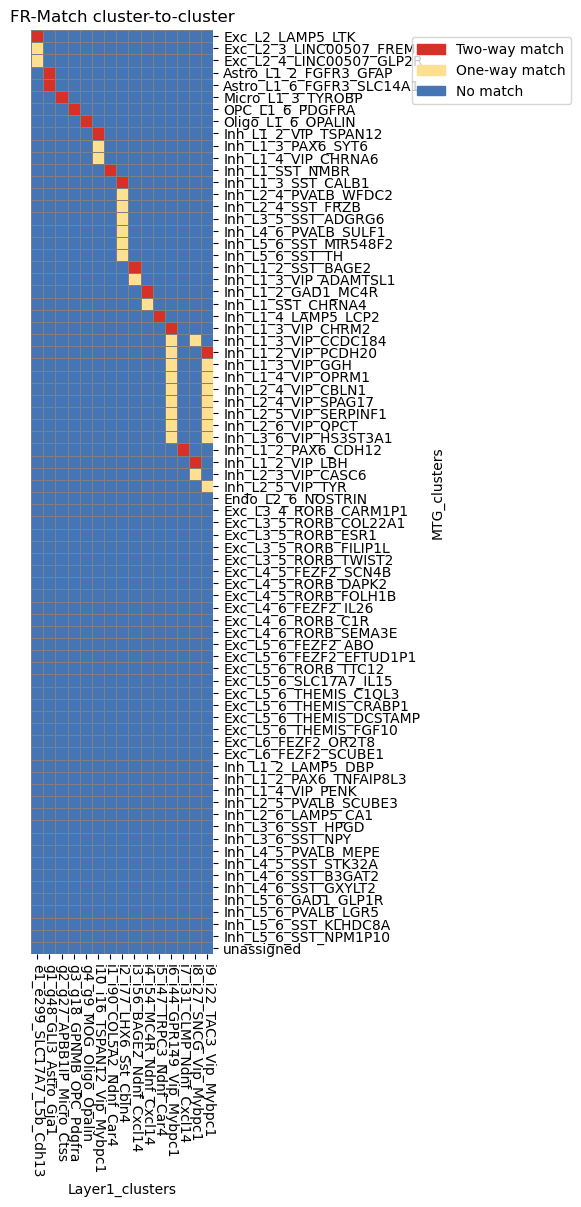

In [32]:
FRmatch.plot_bi_FRmatch(results_layer1toMTG, results_MTGtolayer1, prefix = ["Layer1_", "MTG_"], 
                        reorder = True, marker_legend_loc = (3, 1), 
                       )

**FR-Match uniquely maps cell types reflecting the overlapping anatomic regions.** Using FR-Match, we mapped most of the layer 1 cell types uniquely to one MTG cell type, i.e. 1-to-1 two-way matches. These matches precisely reflect the overlapping anatomic regions in these two independent experiments in that the matched MTG cell types all have an ‘L1’ layer indicator in their nomenclature. The couple exceptions of 1-to-many two-way matches may suggest under-partitioning of the layer 1 cell type; but the multiple matches are next to each other given the order of the MTG cell types follow the hierarchical taxonomy in Figure 1c of Hodge et al. (2019).

### Plot one-directional matching results

We also provide the function plot_FRmatch() that takes in single FRmatch_main() output with argument type = "matches" by default, and optionally type = "padj", to visualize the matching results from one direction.

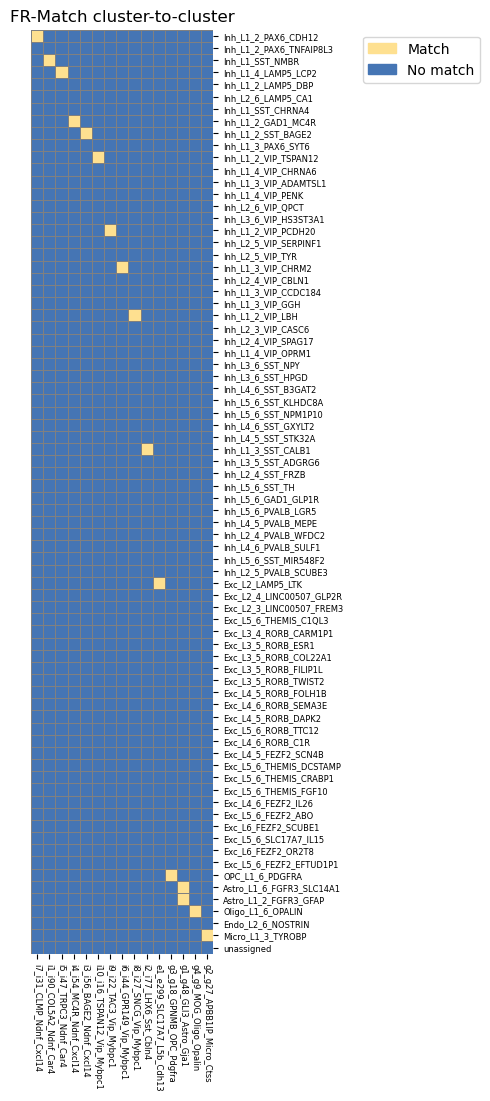

In [20]:
FRmatch.plot_FRmatch(results_layer1toMTG, marker_legend_loc = (2.5, 1))

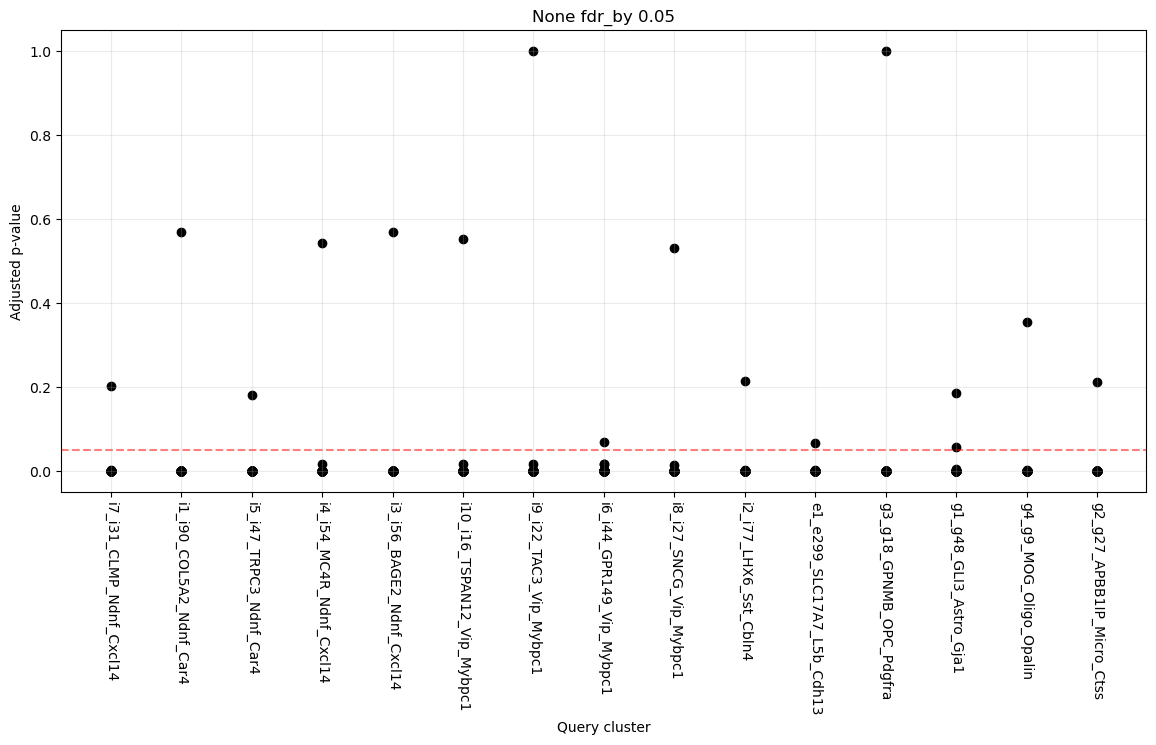

In [21]:
FRmatch.plot_FRmatch(results_layer1toMTG, type_ = "padj", figsize_width = 14, figsize_height = 6)

#### A few remarks:

- For the plots above, note that the prefixes of these cluster names are “query.” and “ref.”, which are coded in our program as default option. We deliberately leave it that way since: 1) it helps our users to distinguish the direction of the one-directional matching; and 2) we sort of regard the one-directional matching as an internal step and strongly recommend to perform the matching in both directions. These prefixes can be changed by specifying the prefix= argument in the FRmatch_main() function.
- Users may also obtain the actual values from above plots by specifying the return.value = TRUE argument in the corresponding plotting function.

Look at the matching results in the other direction

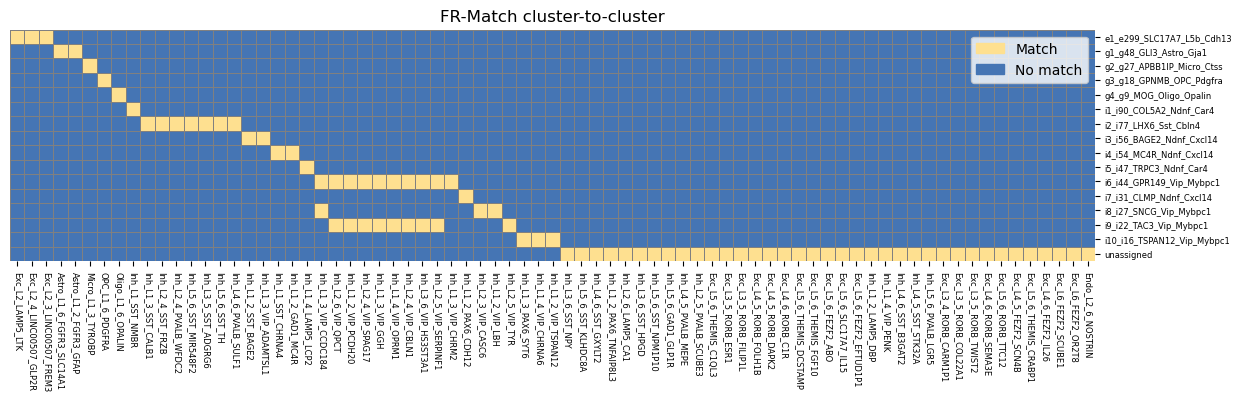

In [22]:
FRmatch.plot_FRmatch(results_MTGtolayer1, figsize_width = 14, figsize_height = 6, 
                     reorder = True, marker_legend_loc = (1, 1))

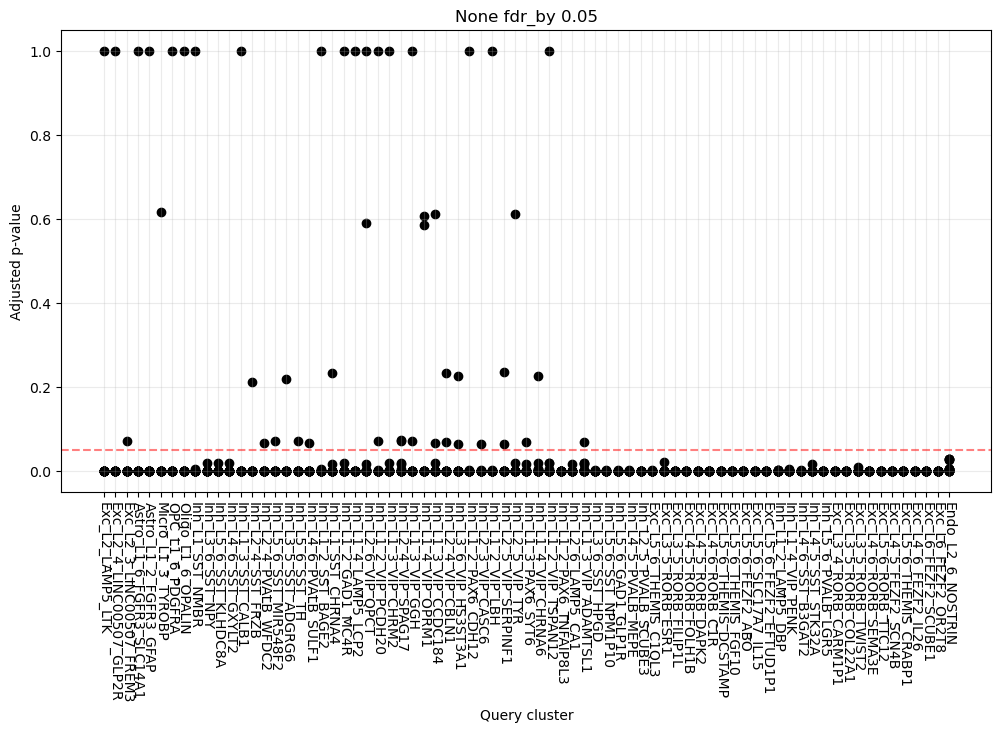

In [23]:
FRmatch.plot_FRmatch(results_MTGtolayer1, type_ = "padj", reorder = False, figsize_width = 12, figsize_height = 6)

It is interesting to see that the matching performance depends on the granularity and/or quality of the reference dataset. It is expected that the reference dataset is more comprehensive, such as the MTG data in this example, so that the one directional matching results in this direction align more with the bi-directional matching results.

## Other useful functions

### Friedman-Rafsky test

We also implemented our own function FRtest() for Friedman-Rafsky (FR) test with customized options. FR test is a multivariate generalization of non-parametric two-sample test. It is a graphical model based on the concept of minimum spanning tree (MST). The MST provides a way to visualize high-dimensional clustered data in a low-dimensional visualization. A minimal working example of FR test and MST visualization is below.

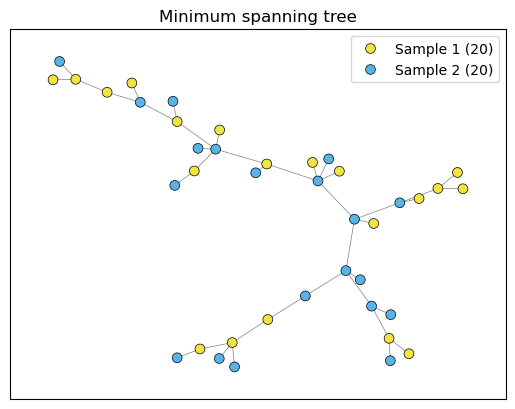

{'runs': 24,
 'runs_samp1': 13,
 'runs_samp2': 11,
 'stat': 0.9815433254336071,
 'p_value': 0.8368375599771128}

In [24]:
samp1 = pd.DataFrame(np.random.random((20, 50)))
samp2 = pd.DataFrame(np.random.random((20, 50)))
FRmatch.FRtest(samp1, samp2, plot_mst = True, title = "Minimum spanning tree")

In the above test, the p-value suggests that no difference between the two simulated samples.

We encourage our users to visually examine their interested cell type clusters on MST plots.

In [25]:
# Investigating 0 vectors
marker_genes = list(set(adata_layer1.uns["markers"]).intersection(set(adata_mtg.var_names)))
len(marker_genes)

adata_mtg[adata_mtg.obs["Clusters"] == "Inh_L1_2_SST_BAGE2", marker_genes].to_df().reset_index(drop = True).iloc[[10, 84, 38, 82, 88, 60, 26, 19, 61, 91],:]

adata_layer1[adata_layer1.obs["cluster_membership"] == "e1_e299_SLC17A7_L5b_Cdh13", marker_genes].to_df().reset_index(drop = True).iloc[[39, 126, 146, 186, 106, 76, 183, 131, 123, 230],:]

v1 = np.array(adata_mtg[adata_mtg.obs["Clusters"] == "Inh_L1_2_SST_BAGE2", marker_genes].to_df().reset_index(drop = True).iloc[88,:])
v2 = np.array(adata_mtg[adata_mtg.obs["Clusters"] == "Inh_L1_2_SST_BAGE2", marker_genes].to_df().reset_index(drop = True).iloc[89,:])

np.linalg.norm(np.array(v1))
np.linalg.norm(np.array(v2))

16.264166771419667